In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_fa_data_norm_b25_t1_mask_t1_normalized_k5_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(684288, 184)
(684288, 1)
validation
(113488, 184)
(113488, 1)
test
(56512, 184)
(56512, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 184)]             0         


 dense (Dense)               (None, 1024)              189440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 878593 (3.35 MB)


Trainable params: 878593 (3.35 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/69 [..............................] - ETA: 1:31 - loss: 0.0144 - STD: 1.0973e-04 - MAE: 0.1027

 6/69 [=>............................] - ETA: 0s - loss: 0.0151 - STD: 1.1284e-04 - MAE: 0.0952  

11/69 [===>..........................] - ETA: 0s - loss: 0.0139 - STD: 1.5141e-04 - MAE: 0.0915

16/69 [=====>........................] - ETA: 0s - loss: 0.0132 - STD: 1.8756e-04 - MAE: 0.0888

21/69 [========>.....................] - ETA: 0s - loss: 0.0127 - STD: 2.2804e-04 - MAE: 0.0878

26/69 [==========>...................] - ETA: 0s - loss: 0.0124 - STD: 2.6059e-04 - MAE: 0.0864

31/69 [============>.................] - ETA: 0s - loss: 0.0122 - STD: 3.0280e-04 - MAE: 0.0861

36/69 [==============>...............] - ETA: 0s - loss: 0.0120 - STD: 3.4082e-04 - MAE: 0.0853

41/69 [================>.............] - ETA: 0s - loss: 0.0119 - STD: 3.8574e-04 - MAE: 0.0851

46/69 [===================>..........] - ETA: 0s - loss: 0.0118 - STD: 4.3354e-04 - MAE: 0.0847

51/69 [=====================>........] - ETA: 0s - loss: 0.0117 - STD: 4.8821e-04 - MAE: 0.0843

56/69 [=======================>......] - ETA: 0s - loss: 0.0116 - STD: 5.5125e-04 - MAE: 0.0842

61/69 [=========================>....] - ETA: 0s - loss: 0.0116 - STD: 6.2478e-04 - MAE: 0.0840

66/69 [===========================>..] - ETA: 0s - loss: 0.0115 - STD: 7.1127e-04 - MAE: 0.0838

69/69 [==============================] - 4s 32ms/step - loss: 0.0115 - STD: 7.7317e-04 - MAE: 0.0836 - val_loss: 0.0125 - val_STD: 0.0021 - val_MAE: 0.0856


Epoch 2/10000


 1/69 [..............................] - ETA: 1s - loss: 0.0107 - STD: 0.0023 - MAE: 0.0813

 6/69 [=>............................] - ETA: 0s - loss: 0.0107 - STD: 0.0026 - MAE: 0.0810

11/69 [===>..........................] - ETA: 0s - loss: 0.0107 - STD: 0.0030 - MAE: 0.0811

16/69 [=====>........................] - ETA: 0s - loss: 0.0107 - STD: 0.0035 - MAE: 0.0811

21/69 [========>.....................] - ETA: 0s - loss: 0.0106 - STD: 0.0041 - MAE: 0.0810

25/69 [=========>....................] - ETA: 0s - loss: 0.0106 - STD: 0.0047 - MAE: 0.0809

30/69 [============>.................] - ETA: 0s - loss: 0.0105 - STD: 0.0058 - MAE: 0.0808

35/69 [==============>...............] - ETA: 0s - loss: 0.0104 - STD: 0.0071 - MAE: 0.0804

40/69 [================>.............] - ETA: 0s - loss: 0.0103 - STD: 0.0089 - MAE: 0.0801

45/69 [==================>...........] - ETA: 0s - loss: 0.0102 - STD: 0.0110 - MAE: 0.0797

50/69 [====================>.........] - ETA: 0s - loss: 0.0101 - STD: 0.0135 - MAE: 0.0793

55/69 [======================>.......] - ETA: 0s - loss: 0.0100 - STD: 0.0159 - MAE: 0.0789

60/69 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 0.0182 - MAE: 0.0786

65/69 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 0.0200 - MAE: 0.0782

69/69 [==============================] - 1s 14ms/step - loss: 0.0098 - STD: 0.0214 - MAE: 0.0780 - val_loss: 0.0100 - val_STD: 0.0390 - val_MAE: 0.0780


Epoch 3/10000


 1/69 [..............................] - ETA: 2s - loss: 0.0088 - STD: 0.0429 - MAE: 0.0742

 6/69 [=>............................] - ETA: 0s - loss: 0.0086 - STD: 0.0429 - MAE: 0.0726

11/69 [===>..........................] - ETA: 0s - loss: 0.0085 - STD: 0.0438 - MAE: 0.0722

16/69 [=====>........................] - ETA: 0s - loss: 0.0084 - STD: 0.0447 - MAE: 0.0719

21/69 [========>.....................] - ETA: 0s - loss: 0.0084 - STD: 0.0454 - MAE: 0.0715

26/69 [==========>...................] - ETA: 0s - loss: 0.0083 - STD: 0.0459 - MAE: 0.0711

31/69 [============>.................] - ETA: 0s - loss: 0.0082 - STD: 0.0466 - MAE: 0.0708

36/69 [==============>...............] - ETA: 0s - loss: 0.0082 - STD: 0.0474 - MAE: 0.0706

41/69 [================>.............] - ETA: 0s - loss: 0.0082 - STD: 0.0480 - MAE: 0.0703

45/69 [==================>...........] - ETA: 0s - loss: 0.0082 - STD: 0.0486 - MAE: 0.0703

50/69 [====================>.........] - ETA: 0s - loss: 0.0082 - STD: 0.0489 - MAE: 0.0701

55/69 [======================>.......] - ETA: 0s - loss: 0.0081 - STD: 0.0493 - MAE: 0.0700

60/69 [=========================>....] - ETA: 0s - loss: 0.0081 - STD: 0.0497 - MAE: 0.0698

65/69 [===========================>..] - ETA: 0s - loss: 0.0080 - STD: 0.0500 - MAE: 0.0696

69/69 [==============================] - 1s 14ms/step - loss: 0.0080 - STD: 0.0504 - MAE: 0.0694 - val_loss: 0.0082 - val_STD: 0.0533 - val_MAE: 0.0713


Epoch 4/10000


 1/69 [..............................] - ETA: 1s - loss: 0.0075 - STD: 0.0585 - MAE: 0.0678

 6/69 [=>............................] - ETA: 0s - loss: 0.0073 - STD: 0.0583 - MAE: 0.0665

11/69 [===>..........................] - ETA: 0s - loss: 0.0073 - STD: 0.0585 - MAE: 0.0660

16/69 [=====>........................] - ETA: 0s - loss: 0.0072 - STD: 0.0589 - MAE: 0.0655

21/69 [========>.....................] - ETA: 0s - loss: 0.0072 - STD: 0.0595 - MAE: 0.0655

26/69 [==========>...................] - ETA: 0s - loss: 0.0072 - STD: 0.0596 - MAE: 0.0653

31/69 [============>.................] - ETA: 0s - loss: 0.0072 - STD: 0.0599 - MAE: 0.0652

36/69 [==============>...............] - ETA: 0s - loss: 0.0072 - STD: 0.0602 - MAE: 0.0652

41/69 [================>.............] - ETA: 0s - loss: 0.0071 - STD: 0.0604 - MAE: 0.0650

46/69 [===================>..........] - ETA: 0s - loss: 0.0071 - STD: 0.0606 - MAE: 0.0649

51/69 [=====================>........] - ETA: 0s - loss: 0.0071 - STD: 0.0608 - MAE: 0.0648

56/69 [=======================>......] - ETA: 0s - loss: 0.0071 - STD: 0.0610 - MAE: 0.0647

61/69 [=========================>....] - ETA: 0s - loss: 0.0071 - STD: 0.0611 - MAE: 0.0646

66/69 [===========================>..] - ETA: 0s - loss: 0.0071 - STD: 0.0612 - MAE: 0.0646

69/69 [==============================] - 1s 14ms/step - loss: 0.0071 - STD: 0.0613 - MAE: 0.0646 - val_loss: 0.0076 - val_STD: 0.0592 - val_MAE: 0.0687


Epoch 5/10000


 1/69 [..............................] - ETA: 1s - loss: 0.0067 - STD: 0.0636 - MAE: 0.0635

 6/69 [=>............................] - ETA: 0s - loss: 0.0069 - STD: 0.0624 - MAE: 0.0638

11/69 [===>..........................] - ETA: 0s - loss: 0.0069 - STD: 0.0627 - MAE: 0.0636

16/69 [=====>........................] - ETA: 0s - loss: 0.0068 - STD: 0.0632 - MAE: 0.0635

21/69 [========>.....................] - ETA: 0s - loss: 0.0068 - STD: 0.0635 - MAE: 0.0633

26/69 [==========>...................] - ETA: 0s - loss: 0.0069 - STD: 0.0635 - MAE: 0.0634

31/69 [============>.................] - ETA: 0s - loss: 0.0068 - STD: 0.0636 - MAE: 0.0634

36/69 [==============>...............] - ETA: 0s - loss: 0.0068 - STD: 0.0636 - MAE: 0.0634

41/69 [================>.............] - ETA: 0s - loss: 0.0068 - STD: 0.0636 - MAE: 0.0634

46/69 [===================>..........] - ETA: 0s - loss: 0.0068 - STD: 0.0636 - MAE: 0.0633

51/69 [=====================>........] - ETA: 0s - loss: 0.0068 - STD: 0.0636 - MAE: 0.0633

56/69 [=======================>......] - ETA: 0s - loss: 0.0068 - STD: 0.0637 - MAE: 0.0633

61/69 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0637 - MAE: 0.0632

66/69 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0638 - MAE: 0.0632

69/69 [==============================] - 1s 14ms/step - loss: 0.0068 - STD: 0.0638 - MAE: 0.0632 - val_loss: 0.0076 - val_STD: 0.0643 - val_MAE: 0.0702


Epoch 6/10000


 1/69 [..............................] - ETA: 1s - loss: 0.0067 - STD: 0.0683 - MAE: 0.0640

 6/69 [=>............................] - ETA: 0s - loss: 0.0067 - STD: 0.0649 - MAE: 0.0631

11/69 [===>..........................] - ETA: 0s - loss: 0.0068 - STD: 0.0648 - MAE: 0.0632

16/69 [=====>........................] - ETA: 0s - loss: 0.0068 - STD: 0.0644 - MAE: 0.0634

21/69 [========>.....................] - ETA: 0s - loss: 0.0068 - STD: 0.0639 - MAE: 0.0634

26/69 [==========>...................] - ETA: 0s - loss: 0.0070 - STD: 0.0635 - MAE: 0.0640

31/69 [============>.................] - ETA: 0s - loss: 0.0072 - STD: 0.0627 - MAE: 0.0647

36/69 [==============>...............] - ETA: 0s - loss: 0.0072 - STD: 0.0618 - MAE: 0.0649

41/69 [================>.............] - ETA: 0s - loss: 0.0072 - STD: 0.0608 - MAE: 0.0649

46/69 [===================>..........] - ETA: 0s - loss: 0.0071 - STD: 0.0603 - MAE: 0.0648

51/69 [=====================>........] - ETA: 0s - loss: 0.0071 - STD: 0.0605 - MAE: 0.0646

56/69 [=======================>......] - ETA: 0s - loss: 0.0071 - STD: 0.0609 - MAE: 0.0645

61/69 [=========================>....] - ETA: 0s - loss: 0.0070 - STD: 0.0612 - MAE: 0.0643

66/69 [===========================>..] - ETA: 0s - loss: 0.0070 - STD: 0.0617 - MAE: 0.0642

69/69 [==============================] - 1s 13ms/step - loss: 0.0070 - STD: 0.0619 - MAE: 0.0642 - val_loss: 0.0074 - val_STD: 0.0627 - val_MAE: 0.0684


Epoch 7/10000


 1/69 [..............................] - ETA: 1s - loss: 0.0067 - STD: 0.0659 - MAE: 0.0624

 6/69 [=>............................] - ETA: 0s - loss: 0.0067 - STD: 0.0649 - MAE: 0.0624

11/69 [===>..........................] - ETA: 0s - loss: 0.0067 - STD: 0.0651 - MAE: 0.0628

16/69 [=====>........................] - ETA: 0s - loss: 0.0067 - STD: 0.0647 - MAE: 0.0627

21/69 [========>.....................] - ETA: 0s - loss: 0.0067 - STD: 0.0647 - MAE: 0.0627

26/69 [==========>...................] - ETA: 0s - loss: 0.0067 - STD: 0.0647 - MAE: 0.0627

31/69 [============>.................] - ETA: 0s - loss: 0.0067 - STD: 0.0649 - MAE: 0.0627

36/69 [==============>...............] - ETA: 0s - loss: 0.0067 - STD: 0.0650 - MAE: 0.0626

41/69 [================>.............] - ETA: 0s - loss: 0.0067 - STD: 0.0652 - MAE: 0.0626

46/69 [===================>..........] - ETA: 0s - loss: 0.0067 - STD: 0.0652 - MAE: 0.0626

51/69 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0653 - MAE: 0.0626

56/69 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0653 - MAE: 0.0626

61/69 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0654 - MAE: 0.0626

66/69 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0654 - MAE: 0.0625

69/69 [==============================] - 1s 13ms/step - loss: 0.0066 - STD: 0.0654 - MAE: 0.0625 - val_loss: 0.0074 - val_STD: 0.0628 - val_MAE: 0.0687


Epoch 8/10000


 1/69 [..............................] - ETA: 2s - loss: 0.0065 - STD: 0.0662 - MAE: 0.0622

 6/69 [=>............................] - ETA: 0s - loss: 0.0066 - STD: 0.0649 - MAE: 0.0622

11/69 [===>..........................] - ETA: 0s - loss: 0.0066 - STD: 0.0651 - MAE: 0.0622

16/69 [=====>........................] - ETA: 0s - loss: 0.0066 - STD: 0.0650 - MAE: 0.0622

21/69 [========>.....................] - ETA: 0s - loss: 0.0066 - STD: 0.0652 - MAE: 0.0622

26/69 [==========>...................] - ETA: 0s - loss: 0.0066 - STD: 0.0653 - MAE: 0.0622

31/69 [============>.................] - ETA: 0s - loss: 0.0066 - STD: 0.0655 - MAE: 0.0623

36/69 [==============>...............] - ETA: 0s - loss: 0.0066 - STD: 0.0656 - MAE: 0.0623

41/69 [================>.............] - ETA: 0s - loss: 0.0066 - STD: 0.0655 - MAE: 0.0623

46/69 [===================>..........] - ETA: 0s - loss: 0.0066 - STD: 0.0656 - MAE: 0.0623

51/69 [=====================>........] - ETA: 0s - loss: 0.0066 - STD: 0.0656 - MAE: 0.0623

56/69 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0656 - MAE: 0.0624

61/69 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0656 - MAE: 0.0624

66/69 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0657 - MAE: 0.0623

69/69 [==============================] - 1s 13ms/step - loss: 0.0066 - STD: 0.0657 - MAE: 0.0624 - val_loss: 0.0075 - val_STD: 0.0656 - val_MAE: 0.0702


Epoch 9/10000


 1/69 [..............................] - ETA: 2s - loss: 0.0067 - STD: 0.0686 - MAE: 0.0637

 6/69 [=>............................] - ETA: 0s - loss: 0.0066 - STD: 0.0657 - MAE: 0.0623

11/69 [===>..........................] - ETA: 0s - loss: 0.0066 - STD: 0.0657 - MAE: 0.0623

15/69 [=====>........................] - ETA: 0s - loss: 0.0066 - STD: 0.0654 - MAE: 0.0622

20/69 [=======>......................] - ETA: 0s - loss: 0.0067 - STD: 0.0652 - MAE: 0.0625

25/69 [=========>....................] - ETA: 0s - loss: 0.0067 - STD: 0.0652 - MAE: 0.0628

30/69 [============>.................] - ETA: 0s - loss: 0.0067 - STD: 0.0647 - MAE: 0.0628

34/69 [=============>................] - ETA: 0s - loss: 0.0067 - STD: 0.0645 - MAE: 0.0628

39/69 [===============>..............] - ETA: 0s - loss: 0.0067 - STD: 0.0645 - MAE: 0.0629

44/69 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0644 - MAE: 0.0628

49/69 [====================>.........] - ETA: 0s - loss: 0.0067 - STD: 0.0645 - MAE: 0.0628

54/69 [======================>.......] - ETA: 0s - loss: 0.0067 - STD: 0.0646 - MAE: 0.0628

59/69 [========================>.....] - ETA: 0s - loss: 0.0067 - STD: 0.0647 - MAE: 0.0628

64/69 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0648 - MAE: 0.0628

69/69 [==============================] - ETA: 0s - loss: 0.0067 - STD: 0.0648 - MAE: 0.0627

69/69 [==============================] - 1s 14ms/step - loss: 0.0067 - STD: 0.0648 - MAE: 0.0627 - val_loss: 0.0076 - val_STD: 0.0660 - val_MAE: 0.0710


Epoch 10/10000


 1/69 [..............................] - ETA: 1s - loss: 0.0067 - STD: 0.0698 - MAE: 0.0639

 6/69 [=>............................] - ETA: 0s - loss: 0.0066 - STD: 0.0660 - MAE: 0.0624

11/69 [===>..........................] - ETA: 0s - loss: 0.0066 - STD: 0.0662 - MAE: 0.0622

16/69 [=====>........................] - ETA: 0s - loss: 0.0066 - STD: 0.0661 - MAE: 0.0622

21/69 [========>.....................] - ETA: 0s - loss: 0.0066 - STD: 0.0661 - MAE: 0.0623

26/69 [==========>...................] - ETA: 0s - loss: 0.0066 - STD: 0.0660 - MAE: 0.0623

31/69 [============>.................] - ETA: 0s - loss: 0.0066 - STD: 0.0659 - MAE: 0.0623

36/69 [==============>...............] - ETA: 0s - loss: 0.0066 - STD: 0.0660 - MAE: 0.0624

41/69 [================>.............] - ETA: 0s - loss: 0.0066 - STD: 0.0657 - MAE: 0.0624

46/69 [===================>..........] - ETA: 0s - loss: 0.0066 - STD: 0.0658 - MAE: 0.0624

51/69 [=====================>........] - ETA: 0s - loss: 0.0066 - STD: 0.0658 - MAE: 0.0624

55/69 [======================>.......] - ETA: 0s - loss: 0.0066 - STD: 0.0659 - MAE: 0.0624

60/69 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0659 - MAE: 0.0623

65/69 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0659 - MAE: 0.0623

69/69 [==============================] - 1s 13ms/step - loss: 0.0066 - STD: 0.0659 - MAE: 0.0623 - val_loss: 0.0075 - val_STD: 0.0625 - val_MAE: 0.0685


Epoch 11/10000


 1/69 [..............................] - ETA: 1s - loss: 0.0064 - STD: 0.0655 - MAE: 0.0612

 6/69 [=>............................] - ETA: 0s - loss: 0.0066 - STD: 0.0664 - MAE: 0.0623

11/69 [===>..........................] - ETA: 0s - loss: 0.0066 - STD: 0.0662 - MAE: 0.0622

16/69 [=====>........................] - ETA: 0s - loss: 0.0066 - STD: 0.0663 - MAE: 0.0623

21/69 [========>.....................] - ETA: 0s - loss: 0.0066 - STD: 0.0663 - MAE: 0.0623

26/69 [==========>...................] - ETA: 0s - loss: 0.0066 - STD: 0.0664 - MAE: 0.0623

31/69 [============>.................] - ETA: 0s - loss: 0.0066 - STD: 0.0664 - MAE: 0.0622

36/69 [==============>...............] - ETA: 0s - loss: 0.0065 - STD: 0.0664 - MAE: 0.0621

41/69 [================>.............] - ETA: 0s - loss: 0.0065 - STD: 0.0664 - MAE: 0.0620

46/69 [===================>..........] - ETA: 0s - loss: 0.0065 - STD: 0.0664 - MAE: 0.0621

51/69 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0664 - MAE: 0.0621

56/69 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0663 - MAE: 0.0621

61/69 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0662 - MAE: 0.0621

66/69 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0662 - MAE: 0.0621

69/69 [==============================] - 1s 13ms/step - loss: 0.0065 - STD: 0.0662 - MAE: 0.0620 - val_loss: 0.0076 - val_STD: 0.0657 - val_MAE: 0.0703


Epoch 12/10000


 1/69 [..............................] - ETA: 1s - loss: 0.0066 - STD: 0.0683 - MAE: 0.0629

 6/69 [=>............................] - ETA: 0s - loss: 0.0065 - STD: 0.0666 - MAE: 0.0619

11/69 [===>..........................] - ETA: 0s - loss: 0.0066 - STD: 0.0664 - MAE: 0.0620

16/69 [=====>........................] - ETA: 0s - loss: 0.0066 - STD: 0.0668 - MAE: 0.0622

21/69 [========>.....................] - ETA: 0s - loss: 0.0066 - STD: 0.0665 - MAE: 0.0622

26/69 [==========>...................] - ETA: 0s - loss: 0.0066 - STD: 0.0661 - MAE: 0.0622

31/69 [============>.................] - ETA: 0s - loss: 0.0066 - STD: 0.0661 - MAE: 0.0622

36/69 [==============>...............] - ETA: 0s - loss: 0.0066 - STD: 0.0659 - MAE: 0.0621

41/69 [================>.............] - ETA: 0s - loss: 0.0066 - STD: 0.0660 - MAE: 0.0621

46/69 [===================>..........] - ETA: 0s - loss: 0.0066 - STD: 0.0661 - MAE: 0.0621

51/69 [=====================>........] - ETA: 0s - loss: 0.0066 - STD: 0.0660 - MAE: 0.0621

56/69 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0660 - MAE: 0.0622

61/69 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0660 - MAE: 0.0623

66/69 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.0653 - MAE: 0.0627

69/69 [==============================] - 1s 13ms/step - loss: 0.0068 - STD: 0.0651 - MAE: 0.0629 - val_loss: 0.0076 - val_STD: 0.0504 - val_MAE: 0.0678


Epoch 13/10000


 1/69 [..............................] - ETA: 1s - loss: 0.0068 - STD: 0.0532 - MAE: 0.0632

 6/69 [=>............................] - ETA: 0s - loss: 0.0071 - STD: 0.0548 - MAE: 0.0659

11/69 [===>..........................] - ETA: 0s - loss: 0.0070 - STD: 0.0549 - MAE: 0.0652

16/69 [=====>........................] - ETA: 0s - loss: 0.0069 - STD: 0.0564 - MAE: 0.0644

21/69 [========>.....................] - ETA: 0s - loss: 0.0069 - STD: 0.0586 - MAE: 0.0639

26/69 [==========>...................] - ETA: 0s - loss: 0.0068 - STD: 0.0605 - MAE: 0.0636

31/69 [============>.................] - ETA: 0s - loss: 0.0068 - STD: 0.0615 - MAE: 0.0633

36/69 [==============>...............] - ETA: 0s - loss: 0.0067 - STD: 0.0623 - MAE: 0.0631

41/69 [================>.............] - ETA: 0s - loss: 0.0067 - STD: 0.0628 - MAE: 0.0630

46/69 [===================>..........] - ETA: 0s - loss: 0.0067 - STD: 0.0631 - MAE: 0.0629

51/69 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0634 - MAE: 0.0628

56/69 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0637 - MAE: 0.0627

61/69 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0640 - MAE: 0.0626

66/69 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0642 - MAE: 0.0625

69/69 [==============================] - 1s 13ms/step - loss: 0.0066 - STD: 0.0643 - MAE: 0.0625 - val_loss: 0.0075 - val_STD: 0.0624 - val_MAE: 0.0685


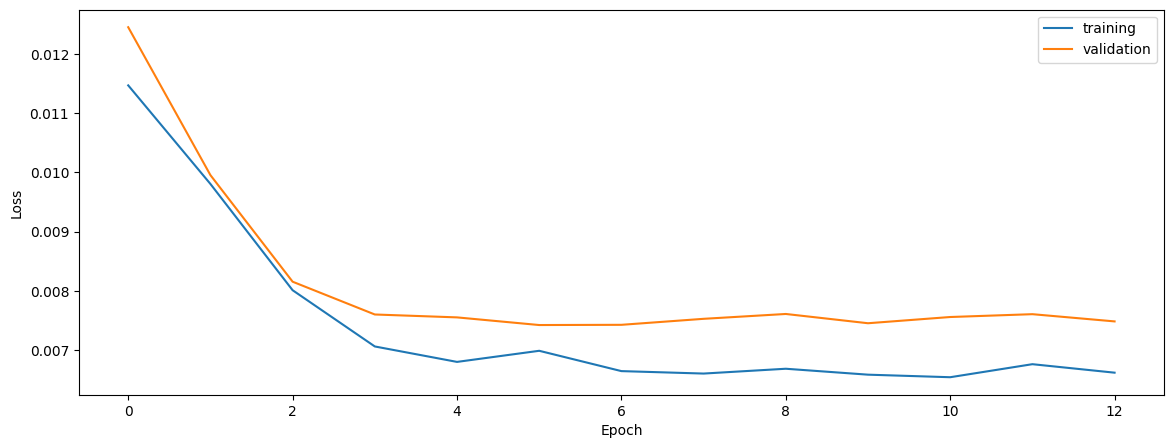

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6279234605811214
0.6373086733628629
0.5781810080847467


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.6244905462924212
0.6124919570102735
0.6006563712869796


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.6345719885439843
0.6188551803492803
0.6131409939765708


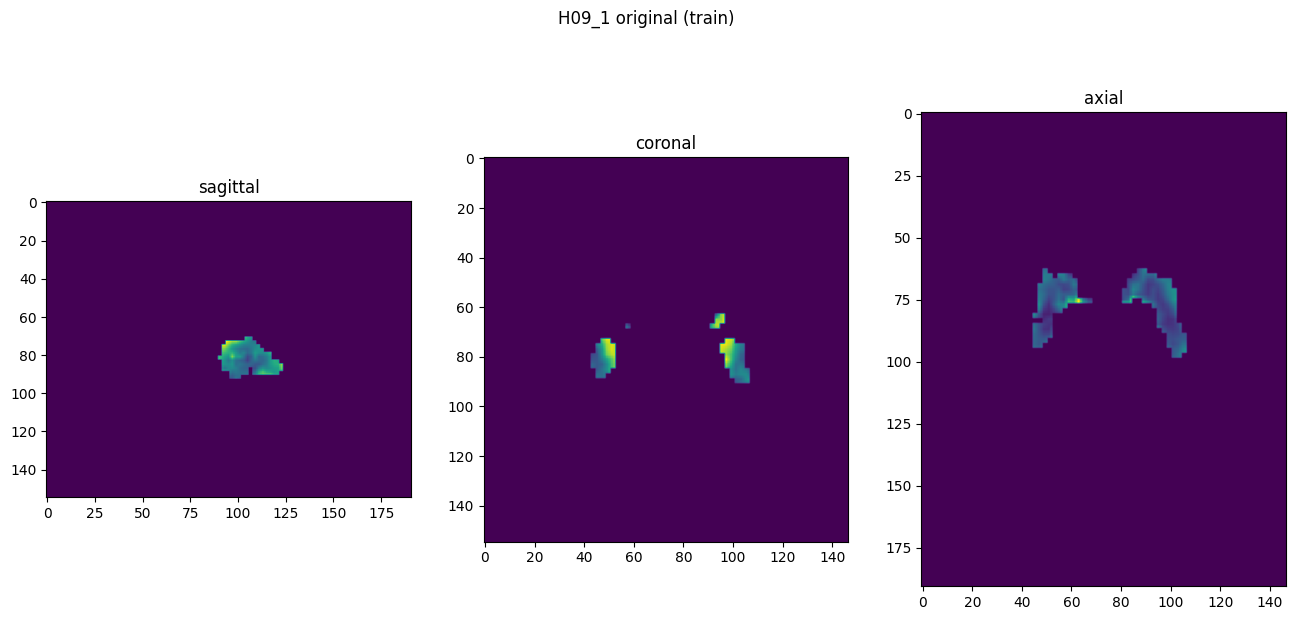

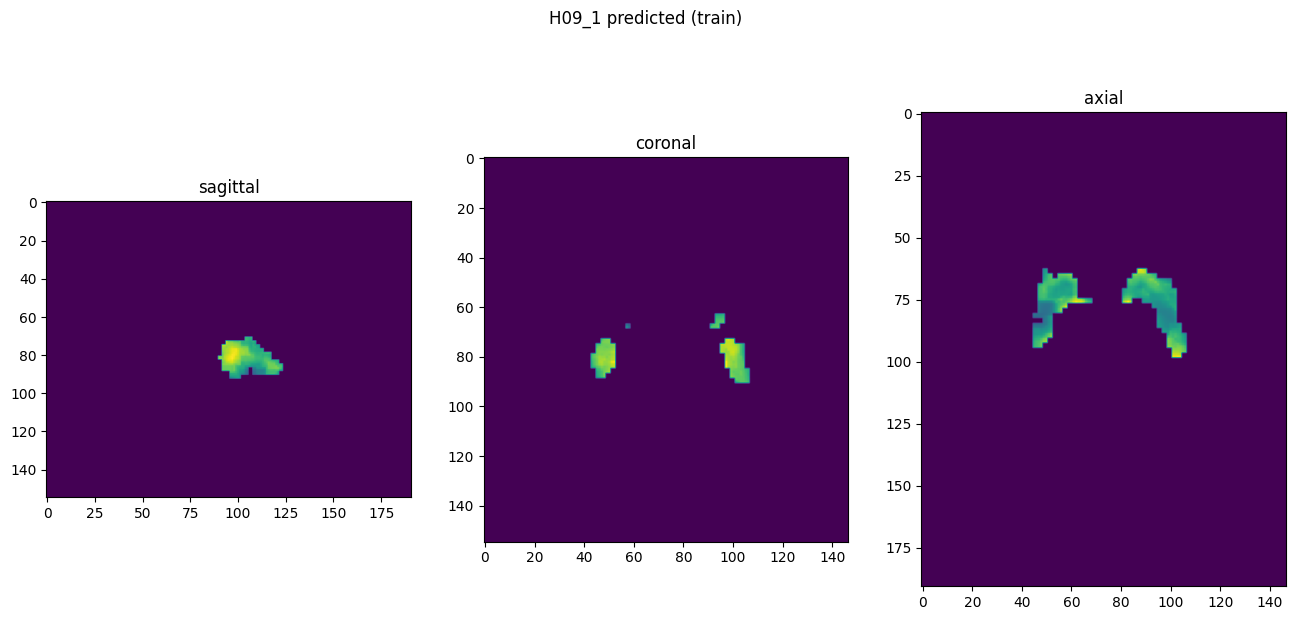

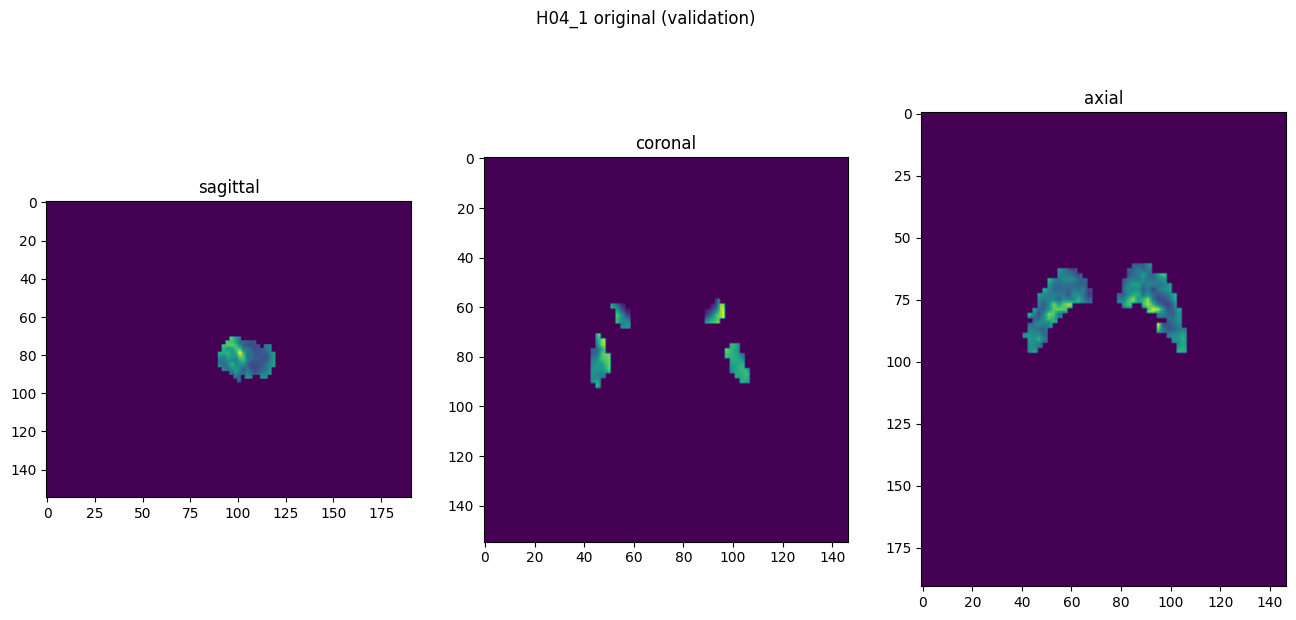

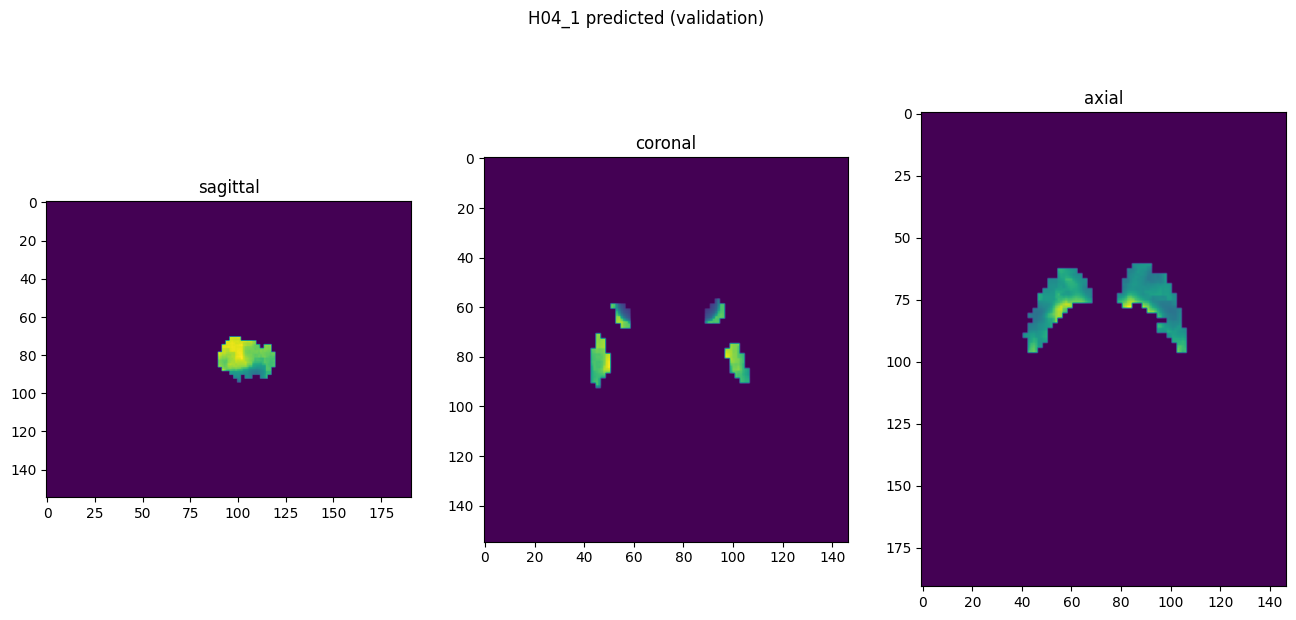

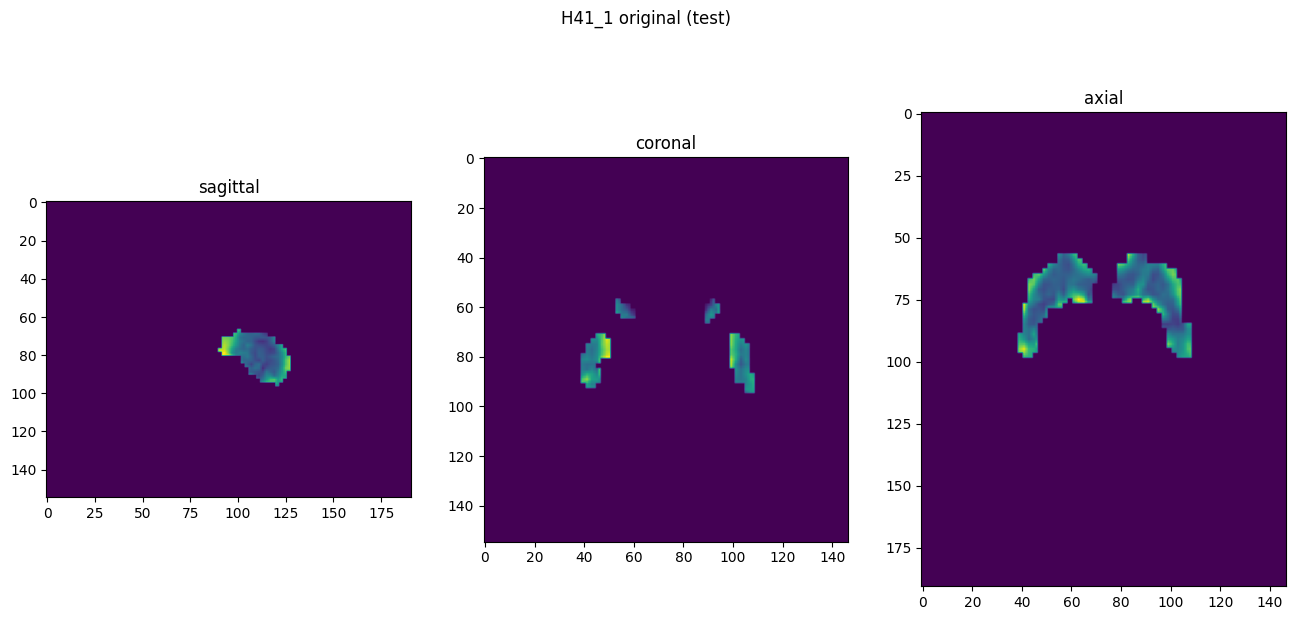

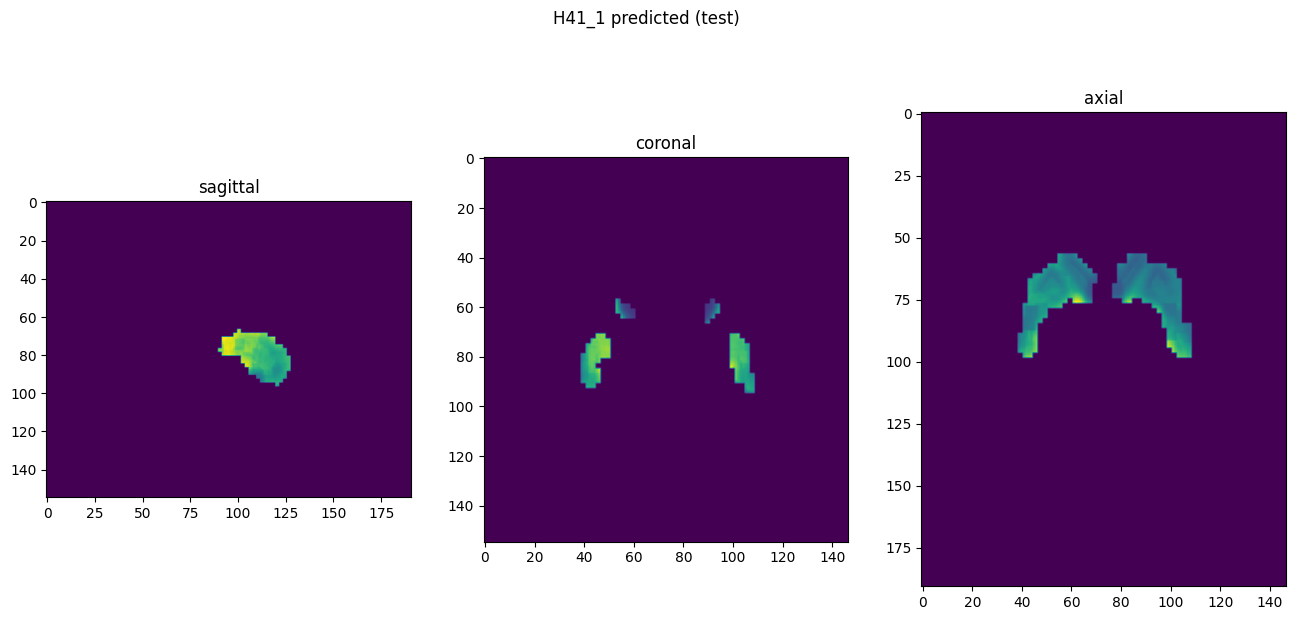

In [10]:
showResults(model, gen, threshold=None, background=False)